In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/STECH/time-series

/content/drive/MyDrive/STECH/time-series


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df = pd.read_csv('FX_EURUSD, 1D.csv')

In [ ]:
cols = ['time','close']
df = df[cols]

In [ ]:
df = df.astype({'time':'datetime64'})

In [ ]:
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date
df['date'] = pd.to_datetime(df['date'])
df.drop('time',axis=1,inplace=True)

In [ ]:
df.Timestamp = pd.to_datetime(df.date, format='%Y-%m-%d')
df.index = df.Timestamp
df = df.resample('MS').mean()
df = df.asfreq(pd.infer_freq(df.index))

In [ ]:
df.head()

,close
date,
2012-10-01,1.298384
2012-11-01,1.283300
2012-12-01,1.312261
2013-01-01,1.331939
2013-02-01,1.330745


**AUTO-ARIMA**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
test_size = 0.3
train_samples = int((1-test_size)*len(df))

In [ ]:
train_data = df[:train_samples]
test_data = df[train_samples:]

In [ ]:
pred_start_date = test_data.index[0]
pred_end_date=test_data.index[-1]
pred_start_date, pred_end_date

(Timestamp('2019-07-01 00:00:00', freq='MS'),
 Timestamp('2022-05-01 00:00:00', freq='MS'))

In [ ]:
auto_model = auto_arima(train_data['close'], start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      m=12,             
                      d=1,          
                      seasonal=True,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-308.246, Time=1.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-275.032, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-307.339, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-308.788, Time=0.71 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-284.054, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-306.829, Time=1.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-304.591, Time=0.69 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-310.927, Time=1.54 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-287.140, Time=0.16 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-307.028, Time=1.41 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC

In [ ]:
auto_model

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

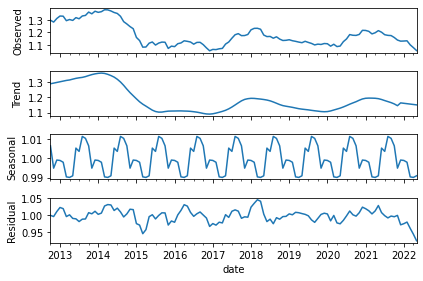

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['close'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.show()

In [ ]:
auto_model.fit(train_data['close'])

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
future_forecast = auto_model.predict(n_periods=len(test_data))

In [ ]:
future_forecast = pd.DataFrame(future_forecast, index=test_data.index, columns=['Prediction'])
future_forecast.head()

,Prediction
date,
2019-07-01,1.127324
2019-08-01,1.136524
2019-09-01,1.136838
2019-10-01,1.129780
2019-11-01,1.111201


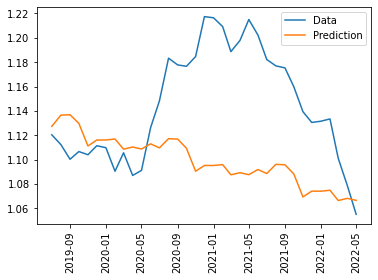

In [ ]:
plt.plot(test_data['close'])
plt.plot(future_forecast)
plt.xticks(rotation='vertical')
plt.legend(('Data','Prediction'))

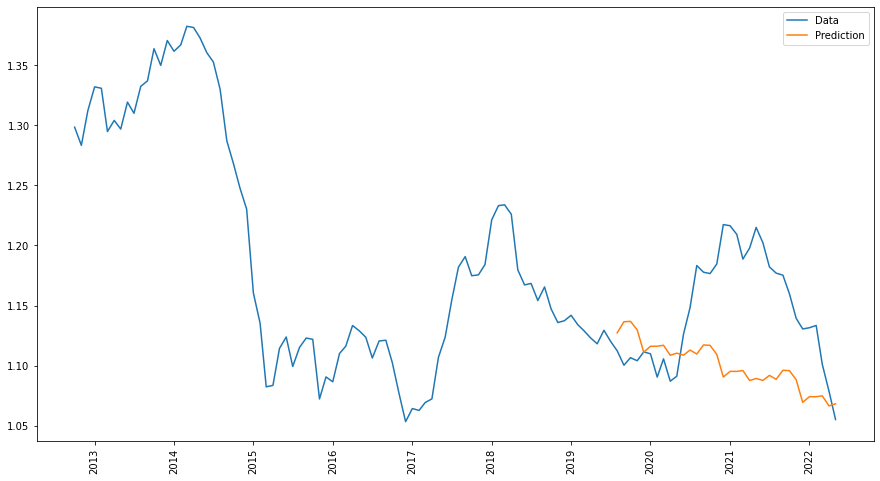

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df['close'])
plt.plot(future_forecast.shift(1))
plt.xticks(rotation='vertical')
plt.legend(('Data','Prediction'))
plt.show()

In [ ]:
residuals_1 = test_data['close'] - future_forecast['Prediction']
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_1/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_1**2)))
# residuals_1

Mean Absolute Percent Error:  0.0475
Root Mean Squared Error:  0.06824631419138372


In [ ]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df[:end_date - timedelta(days=1)]
  model_ARIMA = ARIMA(train_data['close'], order=(2,1,0))
  model_ARIMA_fit = model_ARIMA.fit()
  pred_ARIMA = model_ARIMA_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred_ARIMA.loc[end_date]

In [ ]:
predictions_rolling = pd.DataFrame(data=predictions_rolling,index=test_data.index, columns=['close'])
predictions_rolling['close']

date
2019-07-01    0.000152
2019-08-01   -0.000953
2019-09-01   -0.004751
2019-10-01   -0.005457
2019-11-01   -0.002385
2019-12-01   -0.000687
2020-01-01   -0.000301
2020-02-01   -0.000184
2020-03-01   -0.005676
2020-04-01   -0.002113
2020-05-01   -0.001732
2020-06-01   -0.004498
2020-07-01    0.006275
2020-08-01    0.010023
2020-09-01    0.011434
2020-10-01    0.005151
2020-11-01   -0.002064
2020-12-01    0.000710
2021-01-01    0.008000
2021-02-01    0.005547
2021-03-01   -0.002222
2021-04-01   -0.006294
2021-05-01   -0.002372
2021-06-01    0.004647
2021-07-01   -0.000410
2021-08-01   -0.006925
2021-09-01   -0.004878
2021-10-01   -0.001873
2021-11-01   -0.004362
2021-12-01   -0.007706
2022-01-01   -0.005969
2022-02-01   -0.002036
2022-03-01   -0.000377
2022-04-01   -0.007840
2022-05-01   -0.010863
Freq: MS, Name: close, dtype: float64

In [ ]:
residuals_rolling = test_data['close'] - predictions_rolling['close']
residuals_rolling

date
2019-07-01    1.120214
2019-08-01    1.113287
2019-09-01    1.105086
2019-10-01    1.112094
2019-11-01    1.106432
2019-12-01    1.112116
2020-01-01    1.110127
2020-02-01    1.090667
2020-03-01    1.111321
2020-04-01    1.089163
2020-05-01    1.092908
2020-06-01    1.130736
2020-07-01    1.141965
2020-08-01    1.173234
2020-09-01    1.166301
2020-10-01    1.171439
2020-11-01    1.186635
2020-12-01    1.216641
2021-01-01    1.208394
2021-02-01    1.203636
2021-03-01    1.190842
2021-04-01    1.204144
2021-05-01    1.217351
2021-06-01    1.197582
2021-07-01    1.182560
2021-08-01    1.183870
2021-09-01    1.180152
2021-10-01    1.161671
2021-11-01    1.143727
2021-12-01    1.138216
2022-01-01    1.137498
2022-02-01    1.135456
2022-03-01    1.101519
2022-04-01    1.086555
2022-05-01    1.066033
Freq: MS, Name: close, dtype: float64

In [ ]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_rolling/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_1**2)))

Mean Absolute Percent Error:  1.0012
Root Mean Squared Error:  0.06824631419138372


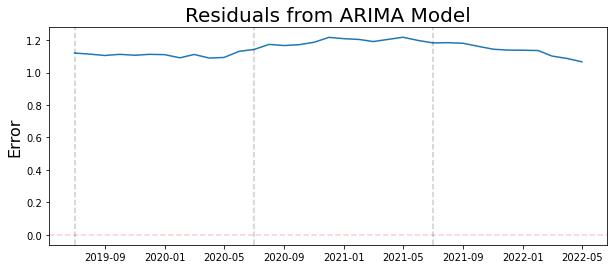

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2019,2022):
    plt.axvline(pd.to_datetime(str(year)+'-07-01'), color='k', linestyle='--',alpha=0.2)

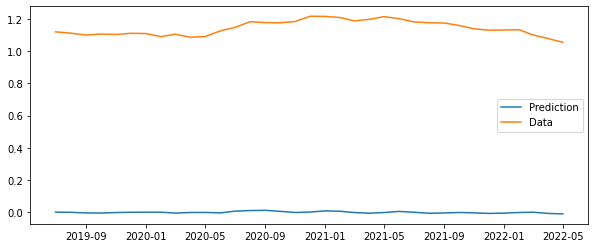

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling['close'])
plt.plot(test_data['close'])
plt.legend(('Prediction','Data'))

**ARMA**

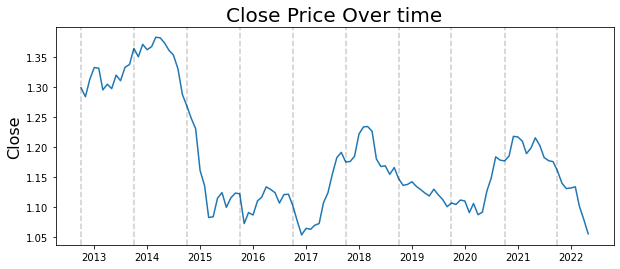

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df.close)
plt.title('Close Price Over time', fontsize=20)
plt.ylabel('Close',fontsize=16)
for year in range(2012, 2022):
  plt.axvline(pd.to_datetime(str(year)+ '-10-01'),color='k', linestyle='--', alpha=0.2)

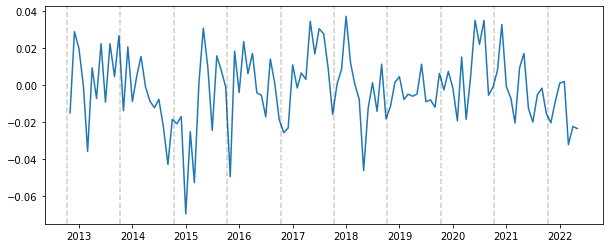

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df.close.diff().dropna())
for year in range(2012,2022):
  plt.axvline(pd.to_datetime(str(year)+'-10-11'), color='k',linestyle='--',alpha=0.2)

In [ ]:
def adf_test(series):
  result = adfuller(series)
  print('ADF Statistics: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
  else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_test(df.close)

ADF Statistics: -2.1489734277601147
p-value: 0.2252832440825921
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
adf_test(df.close.diff().dropna())

ADF Statistics: -7.991566554775922
p-value: 2.466504179978118e-12
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


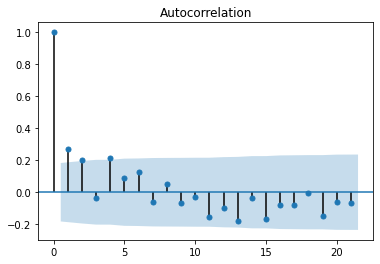

In [ ]:
acf_plot = plot_acf(df.close.diff().dropna())

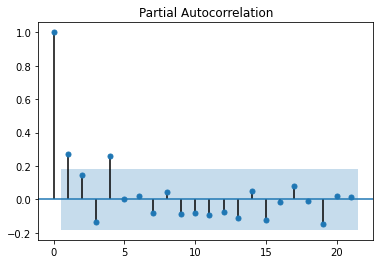

In [ ]:
pacf_plot = plot_pacf(df.close.diff().dropna())

**Model Selection**

In [ ]:
from statsmodels.tsa.arima_model import ARMA
def evaluate_arima_model(X, ar_order):
	# prepare training dataset
  train_size = int(len(X) * 0.7)
  train, test = X[0:train_size], X[train_size:]
  model_ARMA = ARMA(train_data,order=ar_order)
  model_ARMA_fit = model_ARMA.fit()
  pred_start_date = test.index[0]
  pred_end_date = test.index[-1]
  predict_ARMA = model_ARMA_fit.predict(start=pred_start_date, end=pred_end_date)
	# calculate out of sample error
  rmse = np.sqrt(mean_squared_error(test, predict_ARMA))
  return rmse

In [ ]:
def evaluate_models(dataset, p_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for q in q_values:
      order = (p,q)
      try:
        rmse = evaluate_arima_model(dataset, order)
        if rmse < best_score:
          best_score, best_cfg = rmse, order
        print('ARMA%s RMSE=%.3f' % (order,rmse))
      except:
        continue
  print('Best ARMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [1,4]
q_values = [1,2,4]
evaluate_models(df.close, p_values, q_values)

ARMA(1, 1) RMSE=0.016
ARMA(1, 2) RMSE=0.016
ARMA(1, 4) RMSE=0.016
ARMA(4, 1) RMSE=0.016
ARMA(4, 2) RMSE=0.016
Best ARMA(1, 2) RMSE=0.016


In [ ]:
model_arma = ARMA(train_data['close'], order=(1,2))
model_fit_arma = model_arma.fit()
model_fit_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                  115
Model:                     ARMA(1, 2)   Log Likelihood                 295.254
Method:                       css-mle   S.D. of innovations              0.018
Date:                Wed, 01 Jun 2022   AIC                           -580.508
Time:                        08:46:20   BIC                           -566.783
Sample:                    10-01-2012   HQIC                          -574.937
                         - 04-01-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1829      0.051     23.216      0.000       1.083       1.283
ar.L1.close     0.9546      0.029     33.017      0.000       0.898       1.011
ma.L1.close     0.3327      0.108      3.093      0.003       0.122       0.544
ma.L2.close     0.2567      0.099      2.598      0.011       0.063       0.450
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0475           +0.0000j            1.0475            0.0000
MA.1           -0.6481           -1.8642j            1.9736           -0.3032
MA.2           -0.6481           +1.8642j            1.9736            0.3032
-----------------------------------------------------------------------------
"""

In [ ]:
predictions_arma = model_fit_arma.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
residuals_2 = test_data['close'] - predictions_arma
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_2/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_2**2)))

Mean Absolute Percent Error:  0.0114
Root Mean Squared Error:  0.015841691060047153


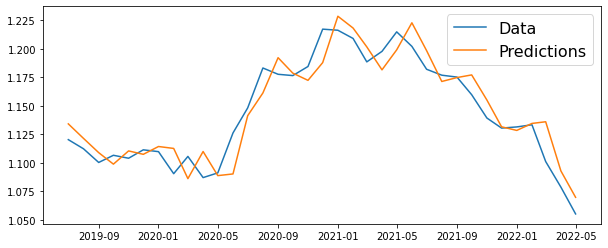

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(test_data['close'])
plt.plot(predictions_arma)
plt.legend(('Data','Predictions'), fontsize=16)

In [ ]:
residuals = test_data['close']-predictions_arma
residuals

date
2019-07-01   -0.013836
2019-08-01   -0.009124
2019-09-01   -0.008612
2019-10-01    0.007764
2019-11-01   -0.006422
2019-12-01    0.003948
2020-01-01   -0.004511
2020-02-01   -0.022171
2020-03-01    0.019505
2020-04-01   -0.022898
2020-05-01    0.002389
2020-06-01    0.035983
2020-07-01    0.006845
2020-08-01    0.021929
2020-09-01   -0.014560
2020-10-01   -0.002165
2020-11-01    0.012153
2020-12-01    0.029367
2021-01-01   -0.012287
2021-02-01   -0.009143
2021-03-01   -0.013173
2021-04-01    0.016218
2021-05-01    0.015792
2021-06-01   -0.020713
2021-07-01   -0.016365
2021-08-01    0.005523
2021-09-01    0.000422
2021-10-01   -0.017381
2021-11-01   -0.015806
2021-12-01   -0.001109
2022-01-01    0.003068
2022-02-01   -0.001176
2022-03-01   -0.034919
2022-04-01   -0.014216
2022-05-01   -0.014577
Freq: MS, dtype: float64

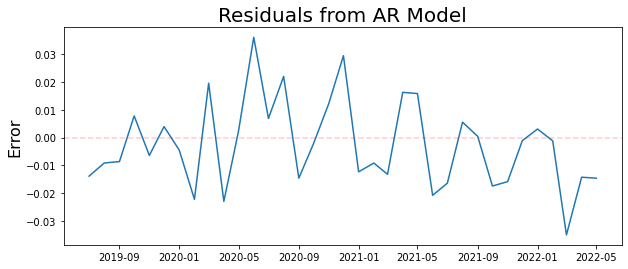

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [ ]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error:  0.015841691060047153


**Forecast the next 12 months**

In [ ]:
pred_start_date

Timestamp('2019-07-01 00:00:00', freq='MS')

In [ ]:
test_data_next_12 = pd.date_range('2022-06-01','2023-05-02',freq='MS').strftime('%Y-%m-%d').tolist()
test_data_next_12

['2022-06-01',
 '2022-07-01',
 '2022-08-01',
 '2022-09-01',
 '2022-10-01',
 '2022-11-01',
 '2022-12-01',
 '2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01']

In [ ]:
new_predict = pd.DataFrame({'DATE':test_data_next_12})
new_predict['DATE'] = pd.to_datetime(new_predict['DATE'])
new_predict['new_predict'] = 0
new_predict.Timestamp = pd.to_datetime(new_predict.DATE, format = '%Y-%m-%d')
new_predict.index = new_predict.Timestamp
new_predict = new_predict.asfreq(pd.infer_freq(new_predict.index))
new_predict.drop('DATE',axis=1,inplace=True)

In [ ]:
new_predict

,new_predict
DATE,
2022-06-01,0
2022-07-01,0
2022-08-01,0
2022-09-01,0
2022-10-01,0
2022-11-01,0
2022-12-01,0
2023-01-01,0
2023-02-01,0


In [ ]:
future_forecast = model_fit_arma.predict(start=test_data.index[0], end=new_predict.index[-1])
future_forecast 

2019-07-01    1.134203
2019-08-01    1.121458
2019-09-01    1.108947
2019-10-01    1.098873
2019-11-01    1.110469
2019-12-01    1.107481
2020-01-01    1.114336
2020-02-01    1.112653
2020-03-01    1.086140
2020-04-01    1.109949
2020-05-01    1.088787
2020-06-01    1.090254
2020-07-01    1.141395
2020-08-01    1.161328
2020-09-01    1.192295
2020-10-01    1.178755
2020-11-01    1.172419
2020-12-01    1.187984
2021-01-01    1.228681
2021-02-01    1.218326
2021-03-01    1.201794
2021-04-01    1.181631
2021-05-01    1.199187
2021-06-01    1.222942
2021-07-01    1.198515
2021-08-01    1.171422
2021-09-01    1.174852
2021-10-01    1.177178
2021-11-01    1.155171
2021-12-01    1.131619
2022-01-01    1.128460
2022-02-01    1.134596
2022-03-01    1.136061
2022-04-01    1.092931
2022-05-01    1.069747
2022-06-01    1.071231
2022-07-01    1.076298
2022-08-01    1.081134
2022-09-01    1.085751
2022-10-01    1.090159
2022-11-01    1.094366
2022-12-01    1.098383
2023-01-01    1.102218
2023-02-01 

In [ ]:
test_data.index[-1]

Timestamp('2022-05-01 00:00:00', freq='MS')

In [ ]:
new_predict['new_predict'] = future_forecast[test_data.index[-1]:]

In [ ]:
test_data

,close
date,
2019-07-01,1.120366
2019-08-01,1.112334
2019-09-01,1.100335
2019-10-01,1.106637
2019-11-01,1.104047
2019-12-01,1.111429
2020-01-01,1.109825
2020-02-01,1.090483
2020-03-01,1.105645


In [ ]:
new_predict

,new_predict
DATE,
2022-06-01,1.071231
2022-07-01,1.076298
2022-08-01,1.081134
2022-09-01,1.085751
2022-10-01,1.090159
2022-11-01,1.094366
2022-12-01,1.098383
2023-01-01,1.102218
2023-02-01,1.105879


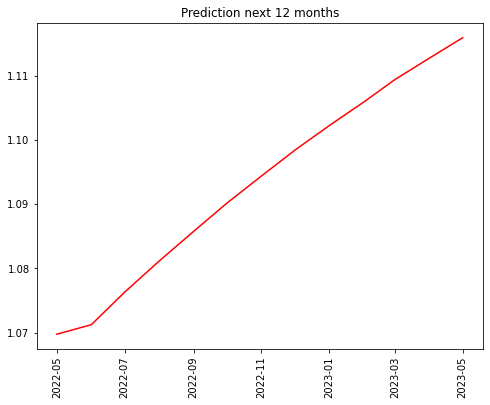

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(future_forecast[test_data.index[-1]:], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.show()

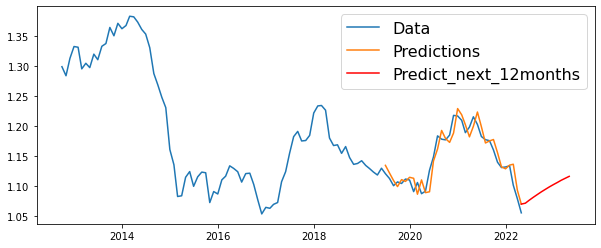

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(predictions_arma)
plt.plot(future_forecast[test_data.index[-1]:], color='red')
plt.legend(('Data','Predictions','Predict_next_12months'), fontsize=16)

**Rolling Forecast**

In [ ]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df[:end_date - timedelta(days=1)]
  model_roll = ARMA(train_data, order=(1,2))
  model_roll_fit = model_roll.fit()
  pred_roll = model_roll_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred_roll.loc[end_date]

In [ ]:
residuals_rolling = test_data['close'] - predictions_rolling

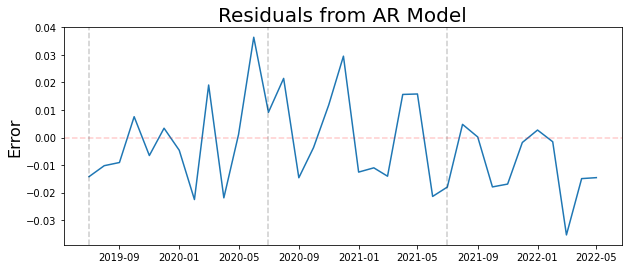

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2019,2022):
    plt.axvline(pd.to_datetime(str(year)+'-07-01'), color='k', linestyle='--',alpha=0.2)

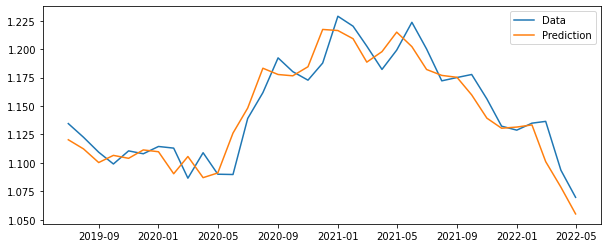

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling)
plt.plot(test_data['close'])
plt.legend(('Data','Prediction'))

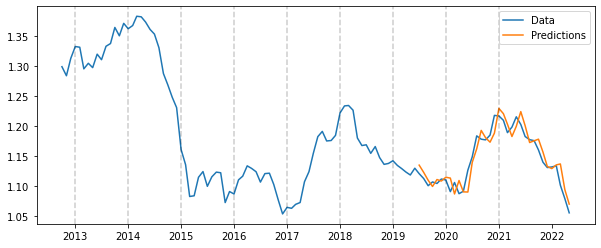

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['close'])
plt.plot(predictions_rolling)
plt.legend(('Data','Predictions'))
for year in range(2013,2022):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--',alpha=0.2)

In [ ]:
new_predict_rolling = new_predict.copy()

In [ ]:
test_data

,close
date,
2019-07-01,1.120366
2019-08-01,1.112334
2019-09-01,1.100335
2019-10-01,1.106637
2019-11-01,1.104047
2019-12-01,1.111429
2020-01-01,1.109825
2020-02-01,1.090483
2020-03-01,1.105645


In [ ]:
# new_predict = pd.DataFrame({'DATE':test_data_next_12})
# new_predict['DATE'] = pd.to_datetime(new_predict['DATE'])
# new_predict['new_predict'] = 0
# new_predict.Timestamp = pd.to_datetime(new_predict.DATE, format = '%Y-%m-%d')
# new_predict.index = new_predict.Timestamp
# new_predict = new_predict.asfreq(pd.infer_freq(new_predict.index))
# new_predict.drop('DATE',axis=1,inplace=True)

In [ ]:
#predict next 12 months
future_forecast_roll = model_roll_fit.predict(start=test_data.index[0], end=new_predict_rolling.index[-1])
future_forecast_roll

2019-07-01    1.134203
2019-08-01    1.121458
2019-09-01    1.108947
2019-10-01    1.098873
2019-11-01    1.110469
2019-12-01    1.107481
2020-01-01    1.114336
2020-02-01    1.112653
2020-03-01    1.086140
2020-04-01    1.109949
2020-05-01    1.088787
2020-06-01    1.090254
2020-07-01    1.141395
2020-08-01    1.161328
2020-09-01    1.192295
2020-10-01    1.178755
2020-11-01    1.172419
2020-12-01    1.187984
2021-01-01    1.228681
2021-02-01    1.218326
2021-03-01    1.201794
2021-04-01    1.181631
2021-05-01    1.199187
2021-06-01    1.222942
2021-07-01    1.198515
2021-08-01    1.171422
2021-09-01    1.174852
2021-10-01    1.177178
2021-11-01    1.155171
2021-12-01    1.131619
2022-01-01    1.128460
2022-02-01    1.134596
2022-03-01    1.136061
2022-04-01    1.092931
2022-05-01    1.069747
2022-06-01    1.071231
2022-07-01    1.076298
2022-08-01    1.081134
2022-09-01    1.085751
2022-10-01    1.090159
2022-11-01    1.094366
2022-12-01    1.098383
2023-01-01    1.102218
2023-02-01 

In [ ]:
predictions_rolling

2019-07-01    1.134578
2019-08-01    1.122566
2019-09-01    1.109417
2019-10-01    1.099077
2019-11-01    1.110589
2019-12-01    1.108052
2020-01-01    1.114460
2020-02-01    1.113017
2020-03-01    1.086580
2020-04-01    1.108965
2020-05-01    1.090074
2020-06-01    1.089818
2020-07-01    1.139078
2020-08-01    1.161783
2020-09-01    1.192353
2020-10-01    1.180249
2020-11-01    1.172750
2020-12-01    1.187808
2021-01-01    1.228958
2021-02-01    1.220198
2021-03-01    1.202680
2021-04-01    1.182206
2021-05-01    1.199169
2021-06-01    1.223631
2021-07-01    1.200145
2021-08-01    1.172169
2021-09-01    1.175081
2021-10-01    1.177745
2021-11-01    1.156279
2021-12-01    1.132318
2022-01-01    1.128819
2022-02-01    1.134958
2022-03-01    1.136524
2022-04-01    1.093646
2022-05-01    1.069747
dtype: float64

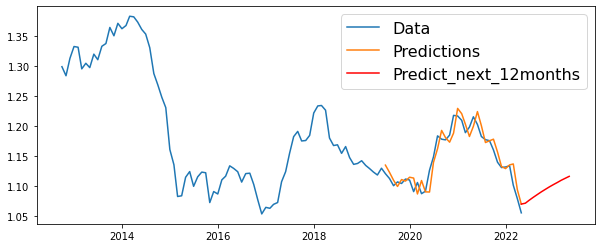

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(predictions_rolling)
plt.plot(future_forecast_roll[test_data.index[-1]:], color='red')
plt.legend(('Data','Predictions','Predict_next_12months'), fontsize=16)

SARIMAX

<BarContainer object of 20 artists>

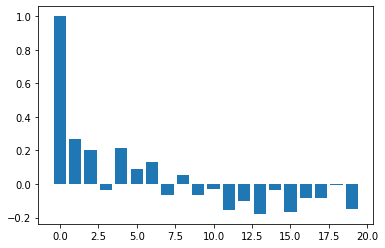

In [ ]:
#ACF
acf_vals = acf(df.close.diff().dropna())
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

**There is not significant lags ( if seasonal there is significant at 12 or 1 year lag (at 20), but it isnt't**

<BarContainer object of 15 artists>

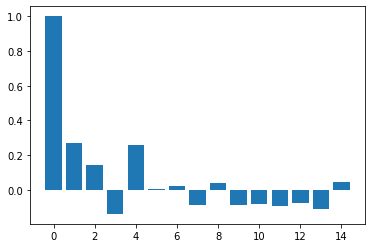

In [ ]:
#PACF
pacf_vals = pacf(df.close.diff().dropna())
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

**Remove the trend. When there is trend, data is not stationary**

In [ ]:
model_SARIMAX = SARIMAX(train_data, order=(2,1,0),seasonal_order=(0,1,1,12))
model_SARIMAX_fit = model_SARIMAX.fit()
model_SARIMAX_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  115
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 250.272
Date:                            Wed, 01 Jun 2022   AIC                           -492.545
Time:                                    08:46:33   BIC                           -482.045
Sample:                                10-01-2012   HQIC                          -488.293
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2684      0.115      2.332      0.020       0.043       0.494
ar.L2          0.1380      0.097      1.424      0.154      -0.052       0.328
ma.S.L12      -0.9482      0.576     -1.645      0.100      -2.078       0.182
sigma2         0.0003      0.000      1.845      0.065   -2.16e-05       0.001
===================================================================================
Ljung-Box (Q):                       42.35   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.37   Prob(JB):                         0.92
Heteroskedasticity (H):               0.57   Skew:                            -0.07
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions_SARIMAX = model_SARIMAX_fit.forecast(len(test_data))
predictions_SARIMAX = pd.DataFrame(predictions_SARIMAX,columns=['close'])
predictions_SARIMAX
predictions_SARIMAX.reset_index(inplace=True)
predictions_SARIMAX['date'] = test_data.index
predictions_SARIMAX.drop('index',axis=1,inplace=True)
predictions_SARIMAX['date'] = pd.to_datetime(predictions_SARIMAX['date'])
predictions_SARIMAX.Timestamp = pd.to_datetime(predictions_SARIMAX.date, format='%Y-%m-%d')
predictions_SARIMAX.index = predictions_SARIMAX.Timestamp
predictions_SARIMAX = predictions_SARIMAX.resample('MS').mean()
predictions_SARIMAX = predictions_SARIMAX.asfreq(pd.infer_freq(predictions_SARIMAX.index))
residuals_SARIMAX = test_data['close'] - predictions_SARIMAX['close']

Text(0, 0.5, 'Error')

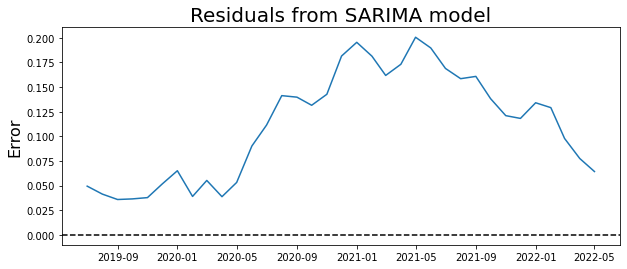

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_SARIMAX)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error',fontsize=16)

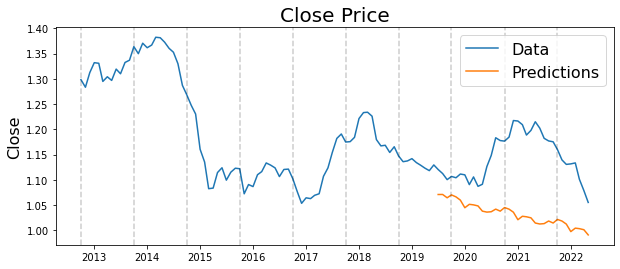

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions_SARIMAX)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Close Price', fontsize=20)
plt.ylabel('Close', fontsize=16)
for year in range(2012,2022):
    plt.axvline(pd.to_datetime(str(year)+'-10-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_SARIMAX/test_data['close'])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0962
Root Mean Squared Error: 0.015841691060047153


Rolling Forecast with SARIMAX

In [ ]:
rolling_SARIMAX = pd.Series()
for train_end in test_data.index:
  train_data = df[:train_end - timedelta(days=1)]
  model_roll_SARIMAX = SARIMAX(train_data, order=(2,1,0),seasonal_order=(0,1,1,12))
  model_roll_SARIMAX_fit = model_roll_SARIMAX.fit()
  pred_roll_SARIMAX = model_roll_SARIMAX_fit.forecast()
  rolling_SARIMAX.loc[train_end] = pred_roll_SARIMAX.loc[train_end]
rolling_SARIMAX

2019-07-01    1.127324
2019-08-01    1.127719
2019-09-01    1.106446
2019-10-01    1.087083
2019-11-01    1.088940
2019-12-01    1.115613
2020-01-01    1.115301
2020-02-01    1.110674
2020-03-01    1.077082
2020-04-01    1.109829
2020-05-01    1.085875
2020-06-01    1.092337
2020-07-01    1.129906
2020-08-01    1.163960
2020-09-01    1.193693
2020-10-01    1.177271
2020-11-01    1.160159
2020-12-01    1.196420
2021-01-01    1.228666
2021-02-01    1.218494
2021-03-01    1.203381
2021-04-01    1.182845
2021-05-01    1.197585
2021-06-01    1.229137
2021-07-01    1.198008
2021-08-01    1.183213
2021-09-01    1.167330
2021-10-01    1.168990
2021-11-01    1.142984
2021-12-01    1.144941
2022-01-01    1.123673
2022-02-01    1.127035
2022-03-01    1.127178
2022-04-01    1.096335
2022-05-01    1.070883
dtype: float64

In [ ]:
residuals_rolling_SARIMAX_roll = test_data['close'] - rolling_SARIMAX

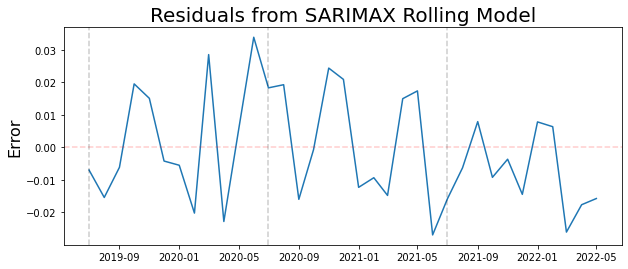

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling_SARIMAX_roll)
plt.title('Residuals from SARIMAX Rolling Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2019,2022):
    plt.axvline(pd.to_datetime(str(year)+'-07-01'), color='k', linestyle='--',alpha=0.2)

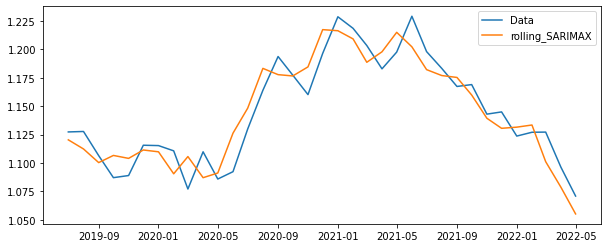

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_SARIMAX)
plt.plot(test_data['close'])
plt.legend(('Data','rolling_SARIMAX'))

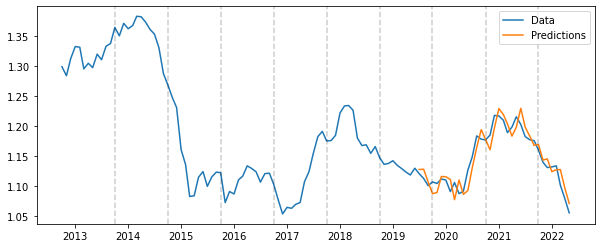

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df['close'])
plt.plot(rolling_SARIMAX)
plt.legend(('Data','Predictions'))
for year in range(2013,2022):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--',alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_rolling_SARIMAX_roll/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_rolling_SARIMAX_roll**2)))

Mean Absolute Percent Error:  0.0128
Root Mean Squared Error:  0.016563402458362214


**Predict 12 months in advance**

In [ ]:
test_data_next_12 = pd.date_range('2022-06-01','2023-05-02',freq='MS').strftime('%Y-%m-%d').tolist()
new_predict = pd.DataFrame({'DATE':test_data_next_12})
new_predict['DATE'] = pd.to_datetime(new_predict['DATE'])
new_predict['new_predict'] = 0
new_predict.Timestamp = pd.to_datetime(new_predict.DATE, format = '%Y-%m-%d')
new_predict.index = new_predict.Timestamp
new_predict = new_predict.asfreq(pd.infer_freq(new_predict.index))
new_predict.drop('DATE',axis=1,inplace=True)

In [ ]:
future_forecast = model_roll_SARIMAX_fit.predict(start=test_data.index[0], end=new_predict.index[-1])

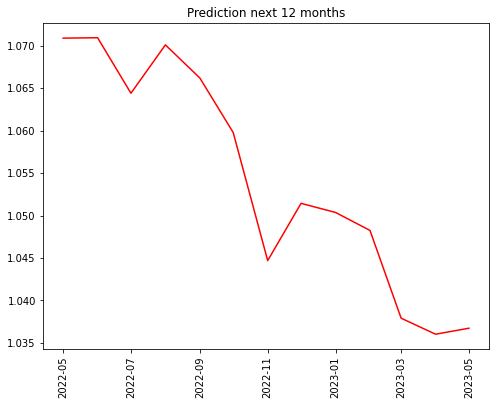

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(future_forecast[test_data.index[-1]:], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.show()

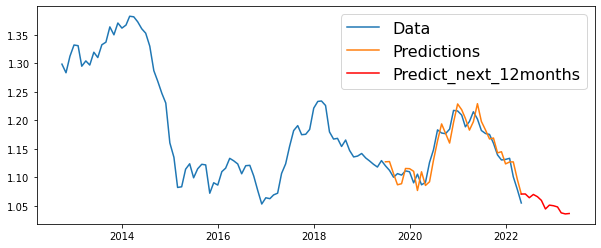

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(rolling_SARIMAX)
plt.plot(future_forecast[test_data.index[-1]:], color='red')
plt.legend(('Data','Predictions','Predict_next_12months'), fontsize=16)